# **LAB 4 "News Classification"**


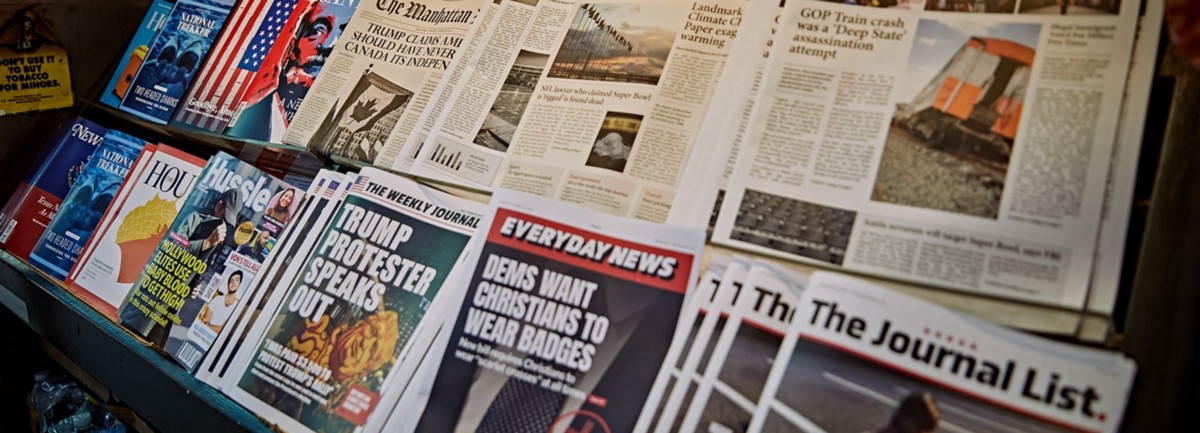



* **Objective:** given a title and description we have to determine whether it belongs to one of four possible categories of news articles.

* **Dataset:** https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset

## 1. Load dataset

In [ ]:
# imports

import re
import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from collections import Counter
from keras.layers import (BatchNormalization, Bidirectional, Conv1D, GRU, Dense, Dropout,
                          Embedding, Flatten, GlobalMaxPooling1D, LSTM, MaxPooling1D)
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# the dataset is stored in Google Drive
# the dataset consists of 2 subsets (train and test)

csv_file_train = "/content/drive/My Drive/train.csv"
csv_file_test = "/content/drive/My Drive/test.csv"

In [ ]:
train = pd.read_csv(csv_file_train)
test = pd.read_csv(csv_file_test)

In [ ]:
train.shape, test.shape

((120000, 3), (7600, 3))

In [ ]:
# we concatenate both train and test subsets in single dataframe for text preprocessing purpose
# later we'll split the dataset into 3 subsets (train, validation, test)

df = pd.concat([train, test],
               ignore_index=True)

In [ ]:
df.shape

(127600, 3)

In [ ]:
df.head(3)

Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...

In [ ]:
# let's rename columns to give them more standard naming

df.rename(columns={
    "Class Index": "class",
    "Title": "title",
    "Description": "description"
},
          inplace=True)

## 2. EDA

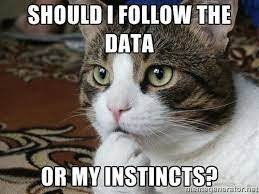

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.2 MB/s eta 0:00:00


In [ ]:
!pip install nltk

In [ ]:
import contractions
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# there are 4 unique labels, where 1-World, 2-Sports, 3-Business, 4-Sci/Tech
# the dataset is balanced

df["class"].value_counts()

3    31900
4    31900
2    31900
1    31900
Name: class, dtype: int64

In [ ]:
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])

In [ ]:
df.head(3)

class                                              title  \
0      2  Wall St. Bears Claw Back Into the Black (Reuters)   
1      2  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      2    Oil and Economy Cloud Stocks' Outlook (Reuters)   

                                         description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...

In [ ]:
# let's assign labels to each class and create another column

labels = {0: "world",
          1: "sports",
          2: "business",
          3: "tech"}
df["label"] = df["class"].map(labels)

In [ ]:
df.head(3)

class                                              title  \
0      2  Wall St. Bears Claw Back Into the Black (Reuters)   
1      2  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      2    Oil and Economy Cloud Stocks' Outlook (Reuters)   

                                         description     label  
0  Reuters - Short-sellers, Wall Street's dwindli...  business  
1  Reuters - Private investment firm Carlyle Grou...  business  
2  Reuters - Soaring crude prices plus worries\ab...  business

In [ ]:
# let's combine `title` and `description` to single a column `summary`

df["summary"] = df["title"] + " " + df["description"]

In [ ]:
df.head(3)

class                                              title  \
0      2  Wall St. Bears Claw Back Into the Black (Reuters)   
1      2  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      2    Oil and Economy Cloud Stocks' Outlook (Reuters)   

                                         description     label  \
0  Reuters - Short-sellers, Wall Street's dwindli...  business   
1  Reuters - Private investment firm Carlyle Grou...  business   
2  Reuters - Soaring crude prices plus worries\ab...  business   

                                             summary  
0  Wall St. Bears Claw Back Into the Black (Reute...  
1  Carlyle Looks Toward Commercial Aerospace (Reu...  
2  Oil and Economy Cloud Stocks' Outlook (Reuters...

In [ ]:
df["label"].value_counts()

business    31900
tech        31900
sports      31900
world       31900
Name: label, dtype: int64

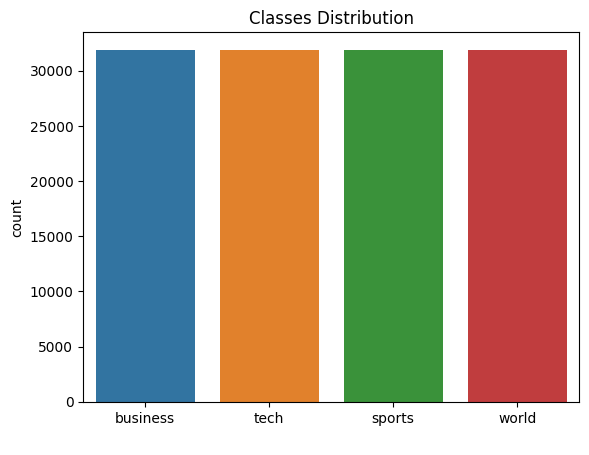

In [ ]:
# visualisation of classes

sns.countplot(x="label",
              data=df,
              palette=sns.color_palette())
plt.xlabel(" ")
plt.ylabel("count")
plt.title("Classes Distribution")
plt.show()

In [ ]:
# there aren't null values and duplicates

print(f"Number of null values: {df.isna().sum().sum()}")
print(f"Number of duplicated values: {df.duplicated().sum()}")

Number of null values: 0
Number of duplicated values: 0


In [ ]:
print(f"max length (in words): {max(df.summary.apply(lambda x: len(str(x).split())))}")
print(f"min length (in words): {min(df.summary.apply(lambda x: len(str(x).split())))}")
print(f"mean length (in words): {round(np.mean((df.summary.apply(lambda x: len(str(x).split())))))}")

max length (in words): 177
min length (in words): 4
mean length (in words): 38


In [ ]:
print(f"max length (in symbols): {max(df.summary.astype(str).apply(len))}")
print(f"min length (in symbols): {min(df.summary.astype(str).apply(len))}")
print(f"mean length (in symbols): {round(np.mean(df.summary.astype(str).apply(len)))}")

max length (in symbols): 1012
min length (in symbols): 17
mean length (in symbols): 236


In [ ]:
business_texts = df.loc[(df["label"] == "business")].summary
tech_texts = df.loc[(df["label"] == "tech")].summary
sports_texts = df.loc[(df["label"] == "sports")].summary
world_texts = df.loc[(df["label"] == "world")].summary

print(f"mean length (in symbols) 'business': {round(np.mean(business_texts.astype(str).apply(len)))}")
print(f"mean length (in symbols) `tech`: {round(np.mean(tech_texts.astype(str).apply(len)))}")
print(f"mean length (in symbols) `sports`: {round(np.mean(sports_texts.astype(str).apply(len)))}")
print(f"mean length (in symbols) `world`: {round(np.mean(world_texts.astype(str).apply(len)))}")

mean length (in symbols) 'business': 241
mean length (in symbols) `tech`: 237
mean length (in symbols) `sports`: 225
mean length (in symbols) `world`: 242


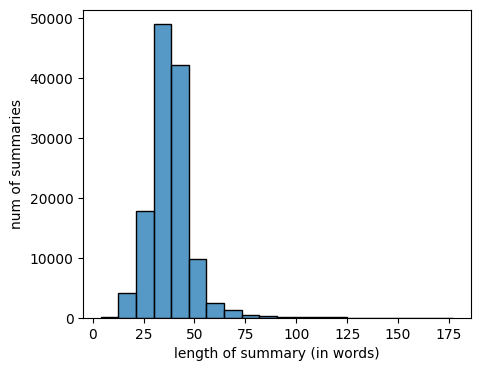

In [ ]:
# length distribution of texts (in words)

plt.figure(figsize=(5, 4))
length = df.summary.apply(lambda x: len(x.split()))
ax = sns.histplot(length, bins=20)
plt.xlabel("length of summary (in words)")
plt.ylabel("num of summaries")
plt.show()

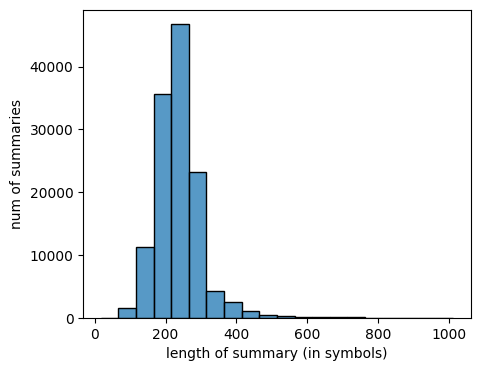

In [ ]:
# length distribution of texts (in symbols)

plt.figure(figsize=(5, 4))
length = df.summary.apply(lambda x: len(x))
ax = sns.histplot(length, bins=20)
plt.xlabel("length of summary (in symbols)")
plt.ylabel("num of summaries")
plt.show()

In [ ]:
# let's create Word Cloud for each class
# we can observe the most frequent words

STOP_WORDS = stopwords.words("english")
STOP_WORDS = set(STOP_WORDS)

# add some news publishers which appear in each category and are very frequent (according to Counter `most_common`)
STOP_WORDS.add("reuters")
STOP_WORDS.add("afp")
STOP_WORDS.add("ap")

In [ ]:
def plot_wc(class_num):
  category = df.loc[df["class"] == class_num]["summary"]

  plt.figure(figsize=(8,8))
  word_cloud = WordCloud(max_words=100,
                         background_color="white",
                         collocations=False,
                         random_state=42,
                         stopwords=STOP_WORDS)
  word_cloud.generate(" ".join(category))

  plt.imshow(word_cloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

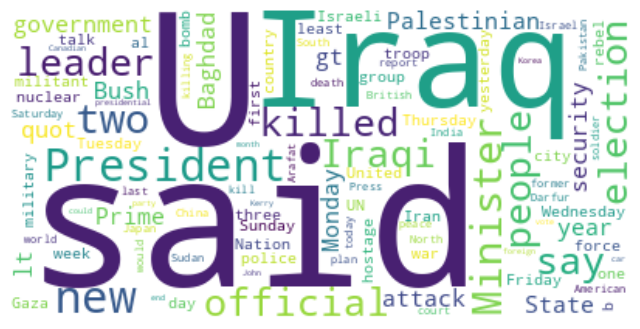

In [ ]:
# world

plot_wc(0)

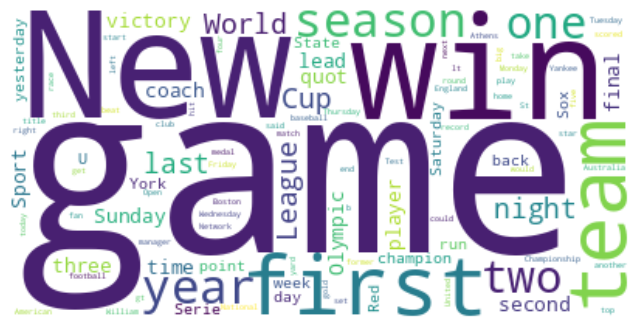

In [ ]:
# sports

plot_wc(1)

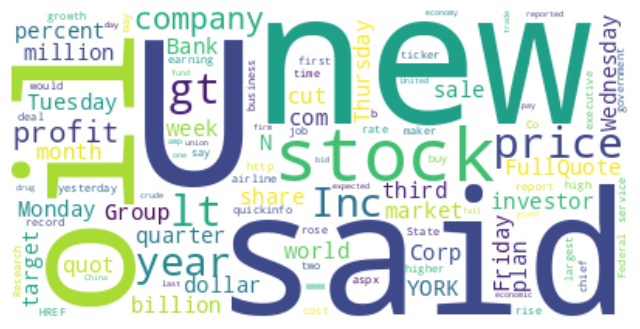

In [ ]:
# business

plot_wc(2)

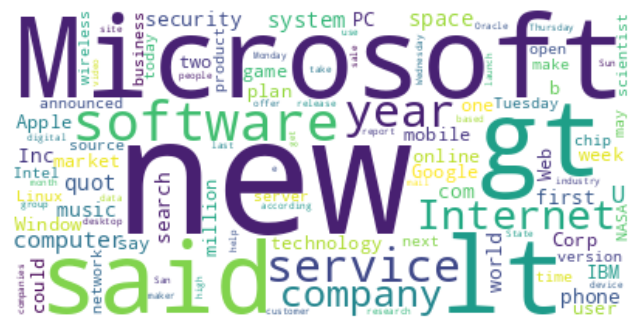

In [ ]:
# tech

plot_wc(3)

## 3. Data Cleaning

Let's clean the summaries from metadata:

1. lower casing
2. removal of digits
3. removal of URLs
4. removal of all hashtags, ampersands and character references with no space
5. removal of contractions
6. removal of punctuations
7. removal of stopwords

In [ ]:
# lower casing

def make_lower(text: str):
  return text.lower()

In [ ]:
# removal of digits

def remove_digits(text: str):
  return re.sub("-?[0-9]+", "", text)

In [ ]:
# removal of URLs

def remove_urls(text: str):
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    return url_pattern.sub(r"", text)

In [ ]:
# removal of all hashtags, ampersands and character references with no space

def remove_ampersands(text: str):
    ampersands_pattern = re.compile(r"[#@&][\S]+")
    return ampersands_pattern.sub(r"", text)

In [ ]:
# removal of contractions

def remove_contraction(text: str):
    words_without_contractions = [contractions.fix(w) for w in text.split()]
    return " ".join(words_without_contractions)

In [ ]:
# removal of punctuations

def remove_punctuation(text: str):
  return re.sub(r"[^\s\w\d]", "", text)

In [ ]:
# removal of stopwords

stops = stopwords.words("english")
stops.extend(["reuters", "ap", "afp"]) # some news publishers which are very frequent

def remove_stopwords(text: str):
  words_without_stops = [w for w in text.split() if w not in stops]
  return " ".join(words_without_stops)

In [ ]:
# tokenization & lemmatization

lemmatizer = WordNetLemmatizer()

def lemmatize_words(text: str):
    return " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)])

In [ ]:
def clean(text: str):
  text = make_lower(text)
  text = remove_digits(text)
  text = remove_urls(text)
  text = remove_ampersands(text)
  text = remove_contraction(text)
  text = remove_punctuation(text)
  text = remove_stopwords(text)
  text = lemmatize_words(text)
  text = " ".join(re.findall(r"[a-z]+", text))
  return text

In [ ]:
# vocabulary size before data cleaning

len(set(" ".join(df.summary).split()))

194175

In [ ]:
df.summary = df.summary.apply(lambda x: clean(x))

In [ ]:
# removal of rare words - we remove some rare words which are of not so much importance
# these are words that occur only once among all words in the corpus (according to Counter().most_common())
# therefore, we keep only 45 000 tokens out of 84 356 unique tokens

all_words = []
df.summary.apply(lambda x : all_words.extend(x.split()))
len(set(all_words))

84361

In [ ]:
freq_words = Counter(all_words).most_common(45000)
freq_words_list = [word for word, _ in freq_words]

In [ ]:
def remove_rarewords(text):
  words_without_rares = " ".join([word for word in text.split() if word in freq_words_list])
  return words_without_rares if words_without_rares else None

In [ ]:
df.summary = df.summary.apply(lambda x: remove_rarewords(x))

In [ ]:
# vocabulary size after data cleaning, we can see a significant reduction in number of unique tokens

len(set(" ".join(df.summary).split()))

45000

In [ ]:
print(f"max length (in words) after cleaning: {max(df.summary.apply(lambda x: len(str(x).split())))}")
print(f"min length (in words) after cleaning: {min(df.summary.apply(lambda x: len(str(x).split())))}")
print(f"mean length (in words) after cleaning: {round(np.mean((df.summary.apply(lambda x: len(str(x).split())))))}")

max length (in words) after cleaning: 99
min length (in words) after cleaning: 2
mean length (in words) after cleaning: 24


In [ ]:
print(f"max length (in symbols) after cleaning: {max(df.summary.astype(str).apply(len))}")
print(f"min length (in symbols) after cleaning: {min(df.summary.astype(str).apply(len))}")
print(f"mean length (in symbols) after cleaning: {round(np.mean(df.summary.astype(str).apply(len)))}")

max length (in symbols) after cleaning: 712
min length (in symbols) after cleaning: 6
mean length (in symbols) after cleaning: 170


In [ ]:
# save cleaned dataframe to csv-file to get cleaned data faster

df.to_csv("cleaned_df.csv", index=False)

In [ ]:
df = pd.read_csv("cleaned_df.csv")

## 4. Train-Validation-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df["summary"]
y = df["class"]

In [ ]:
# in this way, `train`, `val`, `test` set are 60%, 20%, 20% of the dataset respectively
# stratify=True in train_test_split does sampling in proper manner so that we get same amount of values in each sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
     X_train,
     y_train,
     test_size=0.25,
     stratify=y_train,
     random_state=42)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((76560,), (25520,), (25520,))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((76560,), (25520,), (25520,))

In [ ]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

2    19140
1    19140
0    19140
3    19140
Name: class, dtype: int64
1    6380
0    6380
3    6380
2    6380
Name: class, dtype: int64
0    6380
2    6380
1    6380
3    6380
Name: class, dtype: int64


In [ ]:
# find the size of the used vocabulary dictionary

token_counts = Counter()
for sent in X_train:
    token_counts.update(sent.split(" "))

vocabulary_size = len(token_counts.keys()) + 1
vocabulary_size

42183

In [ ]:
# turn the text into a sequence of integers using the keras framework `Tokenizer`

tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X_train)

X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_val_tokenized = tokenizer.texts_to_sequences(X_val)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

embedding_dim = 64
max_text_length = 170 # mean value according to EDA

X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_text_length)
X_val_padded = pad_sequences(X_val_tokenized, maxlen=max_text_length)
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_text_length)

In [ ]:
print(f'Train datashape : {X_train_padded.shape}')
print(f'Test datashape : {X_test_padded.shape}')

Train datashape : (76560, 170)
Test datashape : (25520, 170)


In [ ]:
tokenizer

## 5. Embeddings

#### 1. Word2Vec

In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v_model = Word2Vec(sentences=X_train.apply(lambda x: x.split()),
                     vector_size=embedding_dim,
                     window=5,
                     min_count=3,
                     workers=4,
                     sg=1)

In [ ]:
w2v_model.wv.most_similar("computer")[:5]

[('pc', 0.7704678177833557),
 ('personal', 0.7574246525764465),
 ('macintosh', 0.7341687679290771),
 ('laptop', 0.7270632386207581),
 ('networked', 0.7207942605018616)]

In [ ]:
# save model

w2v_model.wv.save_word2vec_format("embedding_word2vec.txt", binary=False)

In [ ]:
embedding_vector_w2v = {}

with open("./embedding_word2vec.txt") as file:
  for line in tqdm(file):
    value = line.split(" ")
    word = value[0]
    coef = np.array(value[1:], dtype = "float32")
    embedding_vector_w2v[word] = coef

27383it [00:00, 55056.57it/s]


In [ ]:
# prepare embedding matrix

embedding_matrix_w2v = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
  embedding_value_w2v = embedding_vector_w2v.get(word)
  if embedding_value_w2v is not None:
    embedding_matrix_w2v[i] = embedding_value_w2v

In [ ]:
embedding_matrix_w2v

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06171396,  0.10046013,  0.40879524, ..., -0.68199408,
         0.24682482, -0.39994407],
       [-0.0686041 ,  0.03522349,  0.17272462, ..., -0.02353858,
        -0.23057207,  0.21100698],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

#### 2. GloVe

In [ ]:
# !wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [ ]:
embeddings_index_glove = {}

with open("glove.6B.100d.txt") as file:
    for line in file:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index_glove[word] = coefs

print(f"Found {len(embeddings_index_glove)} word vectors.")

Found 40324 word vectors.


In [ ]:
embedding_dim = 100
hits = 0
misses = 0

# prepare embedding matrix
embedding_matrix_glove = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix_glove[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

Converted 23235 words (18947 misses)


In [ ]:
embedding_matrix_glove

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.043959  ,  0.18935999,  0.66109997, ..., -0.14168   ,
         0.92789   ,  0.59057999],
       [-0.13128   , -0.45199999,  0.043399  , ..., -0.30526   ,
        -0.045495  ,  0.56509   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
embedding_matrix_glove.shape

(42183, 100)

#### 3. FastText

In [ ]:
from gensim.models.fasttext import FastText

In [ ]:
fast_Text_model = FastText(sentences=X_train.apply(lambda x: x.split()),
                      vector_size=embedding_dim,
                      window=5,
                      min_count=5,
                      workers=4,
                      sg=1)

In [ ]:
fast_Text_model.wv.most_similar("computer")[:5]

[('excomputer', 0.9746817350387573),
 ('computerized', 0.9209337830543518),
 ('personalcomputer', 0.916110098361969),
 ('computerchip', 0.9151256680488586),
 ('computermaker', 0.8710482716560364)]

In [ ]:
embedding_dim = 100

embedding_matrix_ft = np.random.random((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = fast_Text_model.wv[word]
    except:
        print(word, 'not found')
    if embedding_vector is not None:
        embedding_matrix_ft[i, :] = embedding_vector

In [ ]:
embedding_matrix_ft.shape

(42183, 100)

## 4. Model training

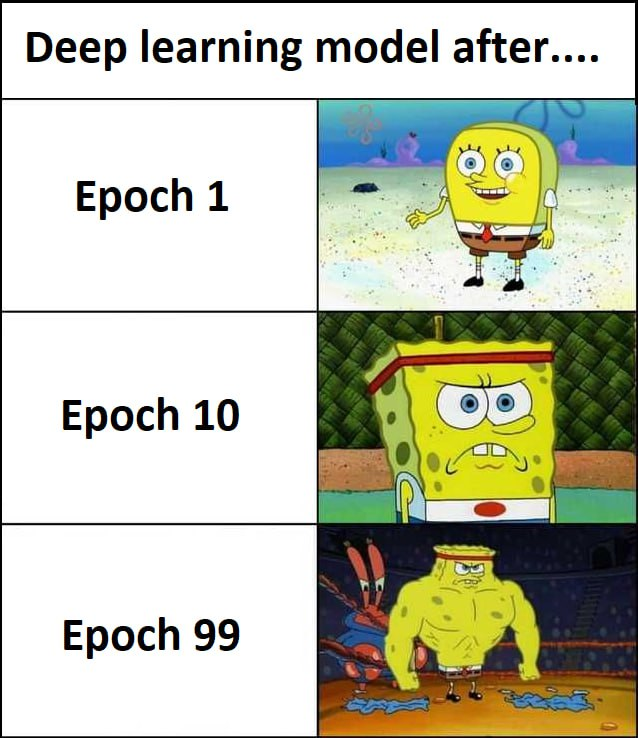

In [ ]:
# function for plotting graphs

def plot_graphs(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs = range(len(acc))

  # plot training and validation accuracy per epoch
  plt.plot(epochs, acc, "r")
  plt.plot(epochs, val_acc, "b")
  plt.title("Training and validation accuracy")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend(["acc", "val_acc"], loc="lower right")
  plt.figure()

  # plot training and validation loss per epoch
  plt.plot(epochs, loss, "r")
  plt.plot(epochs, val_loss, "b")
  plt.title("Training and validation loss")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(["loss", "val_loss"], loc="upper right")
  plt.show()

#### CNN

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

In [ ]:
def get_cnn_model(embedding_matrix, emb_dim):
  model = Sequential()
  model.add(Embedding(input_dim=vocabulary_size,
                      output_dim=embedding_dim,
                      input_length=max_text_length,
                      weights=[embedding_matrix],
                      trainable=False))
  model.add(Conv1D(filters=emb_dim * 2,
                   kernel_size=5,
                   activation="relu"))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters=emb_dim * 2,
                   kernel_size=5,
                   activation="relu"))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.3))
  model.add(Dense(4, activation="softmax"))
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

  return model

In [ ]:
batch_size = 512

train_steps = int(len(X_train_padded) / batch_size)
val_steps = int(len(X_val_padded) / batch_size)
train_steps, val_steps

(149, 49)

Epoch 1/15
74/74 [==============================] - 4s 37ms/step - loss: 0.8570 - accuracy: 0.6368 - val_loss: 0.4326 - val_accuracy: 0.8568
Epoch 2/15
74/74 [==============================] - 2s 28ms/step - loss: 0.4810 - accuracy: 0.8349 - val_loss: 0.4208 - val_accuracy: 0.8542
Epoch 3/15
74/74 [==============================] - 3s 42ms/step - loss: 0.4045 - accuracy: 0.8733 - val_loss: 0.3957 - val_accuracy: 0.8646
Epoch 4/15
74/74 [==============================] - 3s 46ms/step - loss: 0.4031 - accuracy: 0.8678 - val_loss: 0.4562 - val_accuracy: 0.8594
Epoch 5/15
74/74 [==============================] - 3s 36ms/step - loss: 0.4314 - accuracy: 0.8598 - val_loss: 0.3715 - val_accuracy: 0.8776
Epoch 6/15
74/74 [==============================] - 3s 38ms/step - loss: 0.3762 - accuracy: 0.8754 - val_loss: 0.3673 - val_accuracy: 0.8880
Epoch 7/15
74/74 [==============================] - 5s 64ms/step - loss: 0.3631 - accuracy: 0.8818 - val_loss: 0.3776 - val_accuracy: 0.8867
Epoch 8/15
74

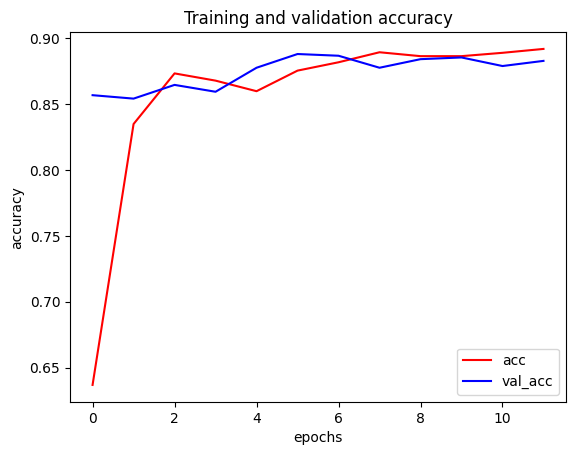

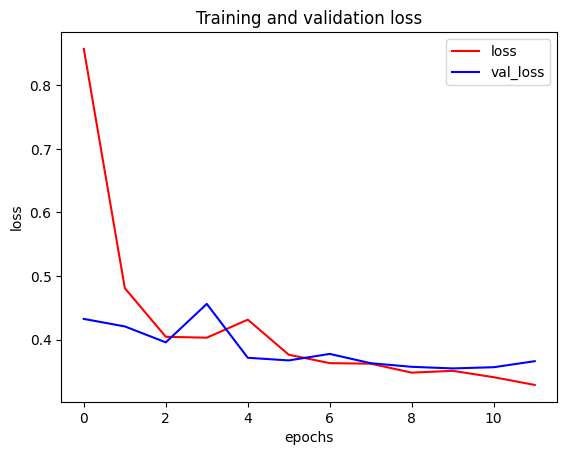

798/798 [==============================] - 9s 10ms/step
Report (Word2Vec + CNN):
              precision    recall  f1-score   support

       world       0.93      0.85      0.89      6380
      sports       0.95      0.96      0.96      6380
    business       0.83      0.88      0.85      6380
        tech       0.85      0.87      0.86      6380

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520



In [ ]:
# Word2Vec + CNN

batch_size = 1024

train_steps = int(len(X_train_padded) / batch_size)
val_steps = int(len(X_val_padded) / batch_size)
train_steps, val_steps

embedding_dim = 64

w2v_cnn_model = get_cnn_model(embedding_matrix_w2v, embedding_dim)
w2v_cnn_history = w2v_cnn_model.fit(X_train_padded,
                                    y_train,
                                    batch_size=32,
                                    epochs=15,
                                    validation_data=(X_val_padded, y_val),
                                    verbose=1,
                                    callbacks=[callbacks],
                                    validation_steps=val_steps,
                                    steps_per_epoch=train_steps)
w2v_cnn_model.summary()

plot_graphs(w2v_cnn_history)

# model evaluation on the test set
w2v_cnn_pred = [np.argmax(arr) for arr in w2v_cnn_model.predict(X_test_padded)]

print("Report (Word2Vec + CNN):")
print(classification_report(y_test,
                            w2v_cnn_pred,
                            target_names=["world", "sports", "business", "tech"]))

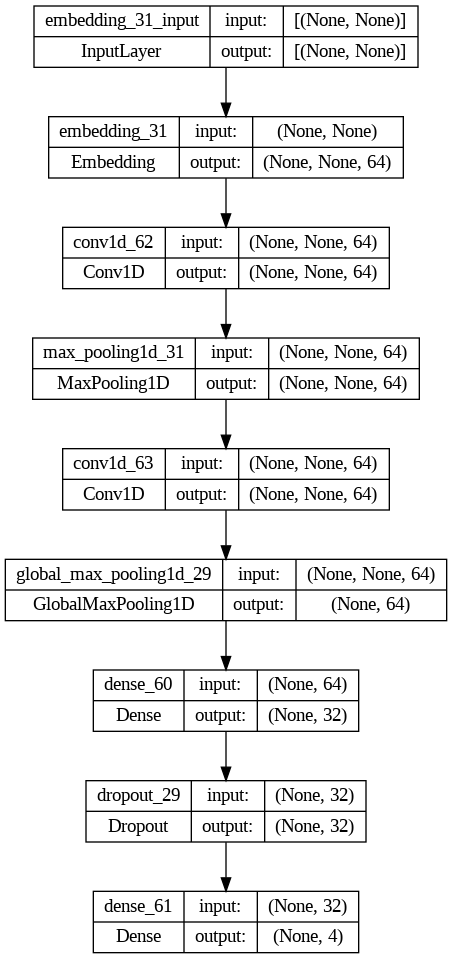

In [ ]:
tf.keras.utils.plot_model(w2v_cnn_model, show_shapes=True)

Epoch 1/20
74/74 [==============================] - 16s 162ms/step - loss: 0.6759 - accuracy: 0.7646 - val_loss: 0.3991 - val_accuracy: 0.8665
Epoch 2/20
74/74 [==============================] - 10s 138ms/step - loss: 0.4348 - accuracy: 0.8579 - val_loss: 0.3755 - val_accuracy: 0.8721
Epoch 3/20
74/74 [==============================] - 12s 157ms/step - loss: 0.4106 - accuracy: 0.8662 - val_loss: 0.3605 - val_accuracy: 0.8721
Epoch 4/20
74/74 [==============================] - 10s 139ms/step - loss: 0.3941 - accuracy: 0.8708 - val_loss: 0.3630 - val_accuracy: 0.8721
Epoch 5/20
74/74 [==============================] - 11s 144ms/step - loss: 0.3891 - accuracy: 0.8740 - val_loss: 0.3493 - val_accuracy: 0.8737
Epoch 6/20
74/74 [==============================] - 12s 164ms/step - loss: 0.3841 - accuracy: 0.8780 - val_loss: 0.3369 - val_accuracy: 0.8799
Epoch 7/20
74/74 [==============================] - 9s 121ms/step - loss: 0.3754 - accuracy: 0.8768 - val_loss: 0.3409 - val_accuracy: 0.8750


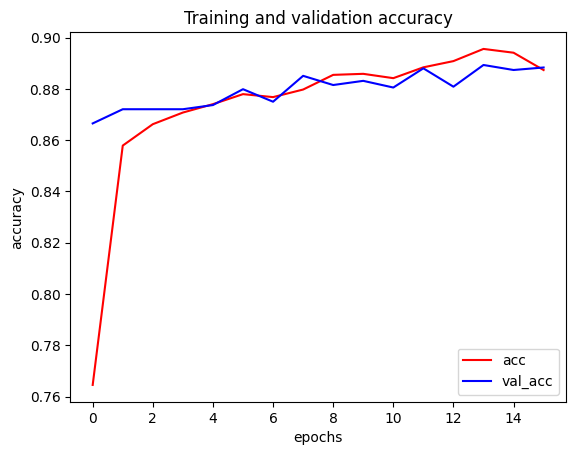

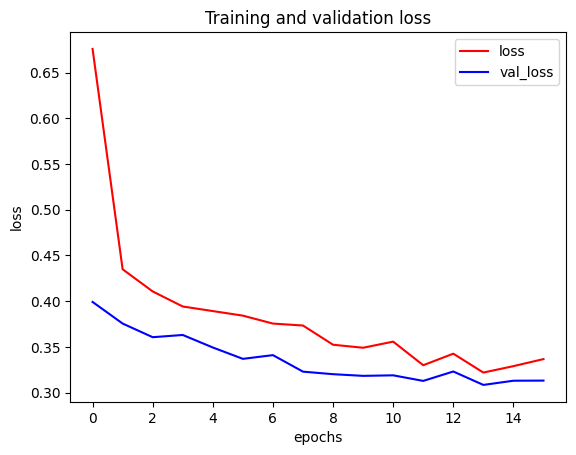

798/798 [==============================] - 12s 15ms/step
Report (Glove + CNN):
              precision    recall  f1-score   support

       world       0.94      0.86      0.90      6380
      sports       0.93      0.98      0.96      6380
    business       0.89      0.81      0.85      6380
        tech       0.82      0.92      0.87      6380

    accuracy                           0.89     25520
   macro avg       0.90      0.89      0.89     25520
weighted avg       0.90      0.89      0.89     25520



In [ ]:
# Glove + CNN

batch_size = 1024

train_steps = int(len(X_train_padded) / batch_size)
val_steps = int(len(X_val_padded) / batch_size)
train_steps, val_steps

embedding_dim = 100

glove_cnn_model = get_cnn_model(embedding_matrix_glove, embedding_dim)
glove_cnn_history = glove_cnn_model.fit(X_train_padded,
                                        y_train,
                                        batch_size=128,
                                        epochs=20,
                                        validation_data=(X_val_padded, y_val),
                                        verbose=1,
                                        callbacks=[callbacks],
                                        validation_steps=val_steps,
                                        steps_per_epoch=train_steps)
glove_cnn_model.summary()

plot_graphs(glove_cnn_history)

# model evaluation on the test set
glove_cnn_pred = [np.argmax(arr) for arr in glove_cnn_model.predict(X_test_padded)]

print("Report (Glove + CNN):")
print(classification_report(y_test,
                            glove_cnn_pred,
                            target_names=["world", "sports", "business", "tech"]))

Epoch 1/15
74/74 [==============================] - 11s 96ms/step - loss: 0.9832 - accuracy: 0.5992 - val_loss: 0.5026 - val_accuracy: 0.8411
Epoch 2/15
74/74 [==============================] - 9s 118ms/step - loss: 0.5454 - accuracy: 0.8193 - val_loss: 0.4240 - val_accuracy: 0.8750
Epoch 3/15
74/74 [==============================] - 6s 80ms/step - loss: 0.4757 - accuracy: 0.8383 - val_loss: 0.4088 - val_accuracy: 0.8685
Epoch 4/15
74/74 [==============================] - 8s 110ms/step - loss: 0.4727 - accuracy: 0.8438 - val_loss: 0.3964 - val_accuracy: 0.8776
Epoch 5/15
74/74 [==============================] - 7s 91ms/step - loss: 0.4072 - accuracy: 0.8746 - val_loss: 0.3927 - val_accuracy: 0.8685
Epoch 6/15
74/74 [==============================] - 7s 93ms/step - loss: 0.4230 - accuracy: 0.8653 - val_loss: 0.3779 - val_accuracy: 0.8750
Epoch 7/15
74/74 [==============================] - 8s 114ms/step - loss: 0.4124 - accuracy: 0.8657 - val_loss: 0.4005 - val_accuracy: 0.8672
Epoch 8/1

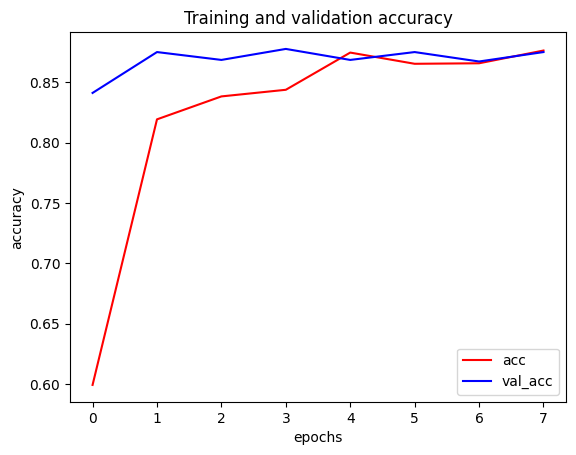

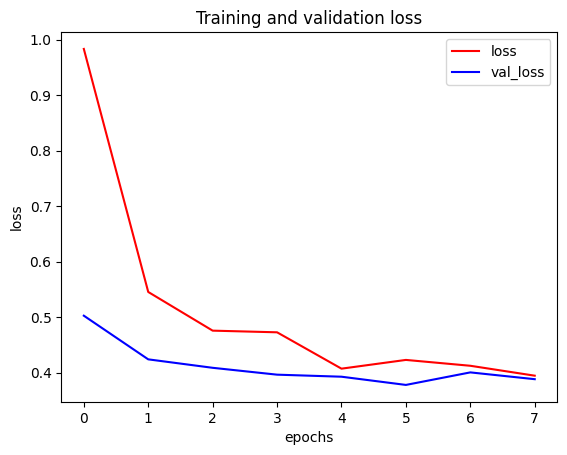

798/798 [==============================] - 11s 14ms/step
Report (FastText + CNN):
              precision    recall  f1-score   support

       world       0.89      0.87      0.88      6380
      sports       0.91      0.98      0.94      6380
    business       0.86      0.84      0.85      6380
        tech       0.87      0.84      0.85      6380

    accuracy                           0.88     25520
   macro avg       0.88      0.88      0.88     25520
weighted avg       0.88      0.88      0.88     25520



In [ ]:
# FastText + CNN

embedding_dim = 100

batch_size = 1024

train_steps = int(len(X_train_padded) / batch_size)
val_steps = int(len(X_val_padded) / batch_size)
train_steps, val_steps

ft_cnn_model = get_cnn_model(embedding_matrix_ft, embedding_dim)
ft_cnn_history = ft_cnn_model.fit(X_train_padded,
                                  y_train,
                                  batch_size=32,
                                  epochs=15,
                                  validation_data=(X_val_padded, y_val),
                                  verbose=1,
                                  callbacks=[callbacks],
                                  steps_per_epoch=train_steps,
                                  validation_steps=val_steps)

ft_cnn_model.summary()

plot_graphs(ft_cnn_history)

# model evaluation on the test set
ft_cnn_pred = [np.argmax(arr) for arr in ft_cnn_model.predict(X_test_padded)]

print("Report (FastText + CNN):")
print(classification_report(y_test,
                            ft_cnn_pred,
                            target_names=["world", "sports", "business", "tech"]))

#### RNN (LSTM)


In [ ]:
def get_lstm_model(embedding_matrix, embed_dim):
  model = Sequential()
  model.add(Embedding(input_dim=vocabulary_size,
                      output_dim=embed_dim,
                      weights=[embedding_matrix],
                      trainable=False))
  model.add(LSTM(128))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.25))
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.25))
  model.add(Dense(4, activation="softmax"))
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])
  return model

Epoch 1/20
74/74 [==============================] - 31s 380ms/step - loss: 0.6946 - accuracy: 0.7411 - val_loss: 0.4177 - val_accuracy: 0.8698
Epoch 2/20
74/74 [==============================] - 21s 291ms/step - loss: 0.4371 - accuracy: 0.8661 - val_loss: 0.3939 - val_accuracy: 0.8646
Epoch 3/20
74/74 [==============================] - 21s 289ms/step - loss: 0.3935 - accuracy: 0.8708 - val_loss: 0.4326 - val_accuracy: 0.8633
Epoch 4/20
74/74 [==============================] - 21s 279ms/step - loss: 0.4157 - accuracy: 0.8737 - val_loss: 0.3910 - val_accuracy: 0.8750
Epoch 5/20
74/74 [==============================] - 23s 317ms/step - loss: 0.4074 - accuracy: 0.8695 - val_loss: 0.4143 - val_accuracy: 0.8646
Epoch 6/20
74/74 [==============================] - 24s 323ms/step - loss: 0.3913 - accuracy: 0.8763 - val_loss: 0.3771 - val_accuracy: 0.8672
Epoch 7/20
74/74 [==============================] - 20s 274ms/step - loss: 0.3562 - accuracy: 0.8851 - val_loss: 0.3582 - val_accuracy: 0.8737

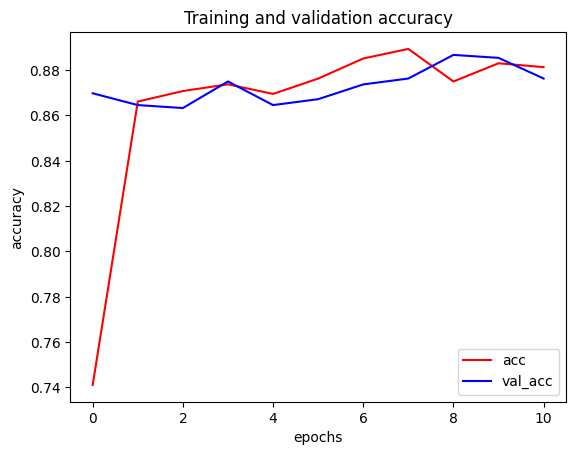

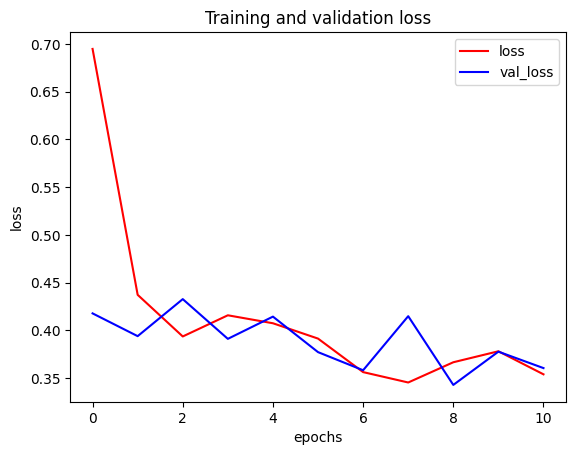

798/798 [==============================] - 94s 117ms/step
Report (Word2Vec + LSTM):
              precision    recall  f1-score   support

       world       0.87      0.90      0.89      6380
      sports       0.93      0.98      0.95      6380
    business       0.89      0.81      0.85      6380
        tech       0.85      0.86      0.85      6380

    accuracy                           0.89     25520
   macro avg       0.88      0.89      0.88     25520
weighted avg       0.88      0.89      0.88     25520



In [ ]:
# Word2Vec + RNN (LSTM)

embedding_dim = 64

batch_size = 1024

train_steps = int(len(X_train_padded) / batch_size)
val_steps = int(len(X_val_padded) / batch_size)
train_steps, val_steps

w2v_lstm_model = get_lstm_model(embedding_matrix_w2v, embedding_dim)
w2v_lstm_history = w2v_lstm_model.fit(X_train_padded,
                                      y_train,
                                      batch_size=32,
                                      epochs=20,
                                      validation_data=(X_val_padded, y_val),
                                      verbose=1,
                                      callbacks=[callbacks],
                                      validation_steps=val_steps,
                                      steps_per_epoch=train_steps)

w2v_lstm_model.summary()

plot_graphs(w2v_lstm_history)

# model evaluation on the test set
w2v_lstm_pred = [np.argmax(arr) for arr in w2v_lstm_model.predict(X_test_padded)]

print("Report (Word2Vec + LSTM):")
print(classification_report(y_test,
                            w2v_lstm_pred,
                            target_names=["world", "sports", "business", "tech"]))

Epoch 1/15
74/74 [==============================] - 55s 665ms/step - loss: 0.6567 - accuracy: 0.7424 - val_loss: 0.4322 - val_accuracy: 0.8483
Epoch 2/15
74/74 [==============================] - 37s 497ms/step - loss: 0.4338 - accuracy: 0.8609 - val_loss: 0.3963 - val_accuracy: 0.8737
Epoch 3/15
74/74 [==============================] - 35s 474ms/step - loss: 0.4163 - accuracy: 0.8708 - val_loss: 0.4042 - val_accuracy: 0.8542
Epoch 4/15
74/74 [==============================] - 38s 522ms/step - loss: 0.4059 - accuracy: 0.8632 - val_loss: 0.3765 - val_accuracy: 0.8652
Epoch 5/15
74/74 [==============================] - 38s 518ms/step - loss: 0.3886 - accuracy: 0.8691 - val_loss: 0.3684 - val_accuracy: 0.8698
Epoch 6/15
74/74 [==============================] - 35s 475ms/step - loss: 0.3717 - accuracy: 0.8733 - val_loss: 0.3480 - val_accuracy: 0.8750
Epoch 7/15
74/74 [==============================] - 38s 519ms/step - loss: 0.3588 - accuracy: 0.8767 - val_loss: 0.3583 - val_accuracy: 0.8698

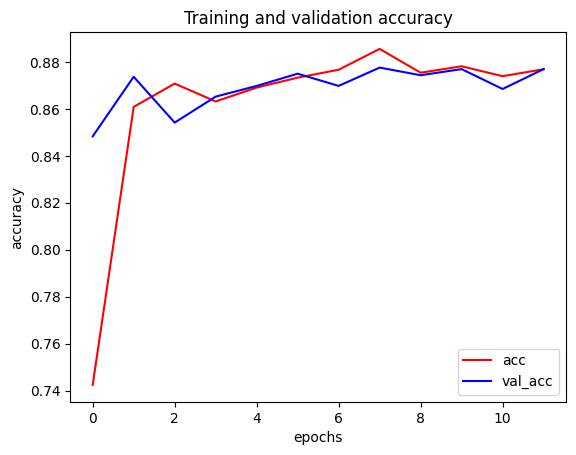

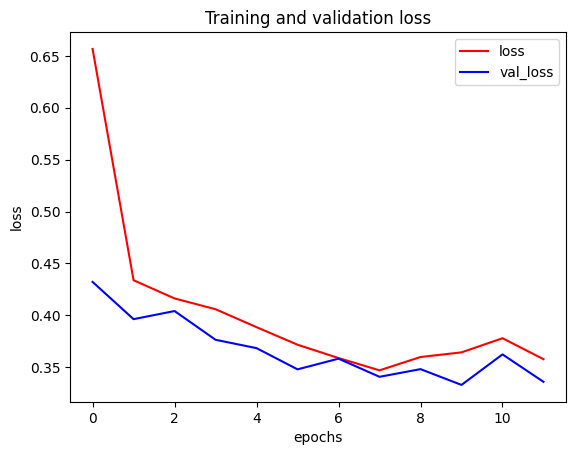

798/798 [==============================] - 99s 124ms/step
Report (Glove + LSTM):
              precision    recall  f1-score   support

       world       0.93      0.86      0.89      6380
      sports       0.94      0.98      0.96      6380
    business       0.87      0.82      0.84      6380
        tech       0.82      0.90      0.86      6380

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520



In [ ]:
# Glove + RNN (LSTM)

embedding_dim = 100

batch_size = 1024
train_steps = int(len(X_train_padded) / batch_size)
val_steps = int(len(X_val_padded) / batch_size)

glove_lstm_model = get_lstm_model(embedding_matrix_glove, embedding_dim)
glove_lstm_history = glove_lstm_model.fit(X_train_padded,
                                          y_train,
                                          batch_size=64,
                                          epochs=15,
                                          validation_data=(X_val_padded, y_val),
                                          verbose=1,
                                          callbacks=[callbacks],
                                          validation_steps=val_steps,
                                          steps_per_epoch=train_steps)

glove_lstm_model.summary()

plot_graphs(glove_lstm_history)

# model evaluation on the test set
glove_lstm_pred = [np.argmax(arr) for arr in glove_lstm_model.predict(X_test_padded)]

print("Report (Glove + LSTM):")
print(classification_report(y_test,
                            glove_lstm_pred,
                            target_names=["world", "sports", "business", "tech"]))

Epoch 1/15
149/149 [==============================] - 115s 655ms/step - loss: 0.5082 - accuracy: 0.8251 - val_loss: 0.3712 - val_accuracy: 0.8776
Epoch 2/15
149/149 [==============================] - 90s 609ms/step - loss: 0.3702 - accuracy: 0.8823 - val_loss: 0.3714 - val_accuracy: 0.8801
Epoch 3/15
149/149 [==============================] - 88s 587ms/step - loss: 0.3715 - accuracy: 0.8803 - val_loss: 0.3492 - val_accuracy: 0.8849
Epoch 4/15
149/149 [==============================] - 94s 629ms/step - loss: 0.3554 - accuracy: 0.8831 - val_loss: 0.3456 - val_accuracy: 0.8842
Epoch 5/15
149/149 [==============================] - 85s 566ms/step - loss: 0.3380 - accuracy: 0.8906 - val_loss: 0.3280 - val_accuracy: 0.8868
Epoch 6/15
149/149 [==============================] - 80s 538ms/step - loss: 0.3260 - accuracy: 0.8923 - val_loss: 0.3282 - val_accuracy: 0.8811
Epoch 7/15
149/149 [==============================] - 93s 622ms/step - loss: 0.3380 - accuracy: 0.8880 - val_loss: 0.3270 - val_a

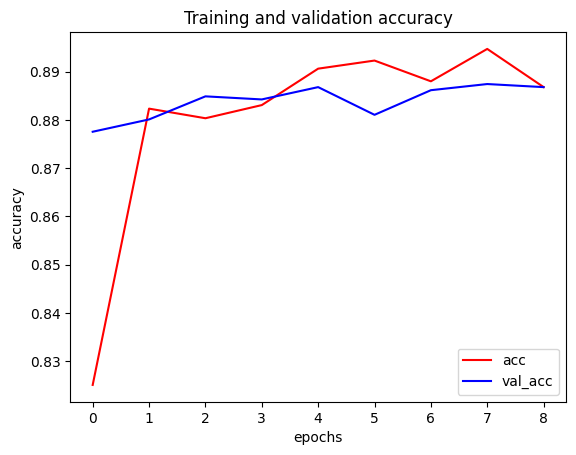

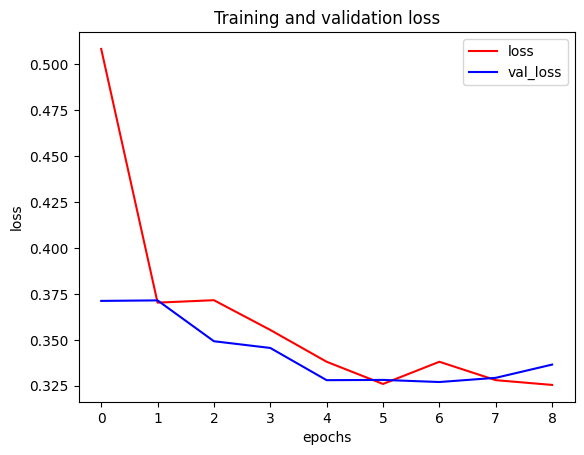

798/798 [==============================] - 115s 143ms/step
Report (FastText + LSTM):
              precision    recall  f1-score   support

       world       0.87      0.90      0.89      6380
      sports       0.96      0.96      0.96      6380
    business       0.88      0.84      0.86      6380
        tech       0.87      0.88      0.87      6380

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520



In [ ]:
# FastText + RNN (LSTM)

embedding_dim = 100

batch_size = 512
train_steps = int(len(X_train_padded) / batch_size)
val_steps = int(len(X_val_padded) / batch_size)

ft_lstm_model = get_lstm_model(embedding_matrix_ft, embedding_dim)
ft_lstm_history = ft_lstm_model.fit(X_train_padded,
                                    y_train,
                                    batch_size=32,
                                    epochs=15,
                                    validation_data=(X_val_padded, y_val),
                                    verbose=1,
                                    callbacks=[callbacks],
                                    validation_steps=val_steps,
                                    steps_per_epoch=train_steps)

ft_lstm_model.summary()

plot_graphs(ft_lstm_history)

# model evaluation on the test set
ft_lstm_pred = [np.argmax(arr) for arr in ft_lstm_model.predict(X_test_padded)]

print("Report (FastText + LSTM):")
print(classification_report(y_test,
                            ft_lstm_pred,
                            target_names=["world", "sports", "business", "tech"]))

#### BiLSTM

In [ ]:
def get_bilstm_model(embedding_matrix):
  model=Sequential()
  model.add(Embedding(input_dim=vocabulary_size,
                      output_dim=embedding_dim,
                      input_length=max_text_length,
                      weights=[embedding_matrix],
                      trainable=False))
  model.add(Bidirectional(LSTM(128, dropout=0.2)))
  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.25))
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.25))
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.25))
  model.add(Dense(4, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

  return model

Epoch 1/8
25/25 [==============================] - 66s 2s/step - loss: 1.0461 - accuracy: 0.5475 - val_loss: 0.5099 - val_accuracy: 0.8500
Epoch 2/8
25/25 [==============================] - 37s 2s/step - loss: 0.4976 - accuracy: 0.8431 - val_loss: 0.4364 - val_accuracy: 0.8625
Epoch 3/8
25/25 [==============================] - 31s 1s/step - loss: 0.4351 - accuracy: 0.8612 - val_loss: 0.3784 - val_accuracy: 0.8781
Epoch 4/8
25/25 [==============================] - 28s 1s/step - loss: 0.3866 - accuracy: 0.8756 - val_loss: 0.3811 - val_accuracy: 0.8844
Epoch 5/8
25/25 [==============================] - 36s 1s/step - loss: 0.4383 - accuracy: 0.8569 - val_loss: 0.3940 - val_accuracy: 0.8875
Epoch 6/8
25/25 [==============================] - 43s 2s/step - loss: 0.4178 - accuracy: 0.8669 - val_loss: 0.3818 - val_accuracy: 0.8844
Epoch 7/8
25/25 [==============================] - 37s 2s/step - loss: 0.3943 - accuracy: 0.8806 - val_loss: 0.3713 - val_accuracy: 0.8906
Epoch 8/8
25/25 [==========

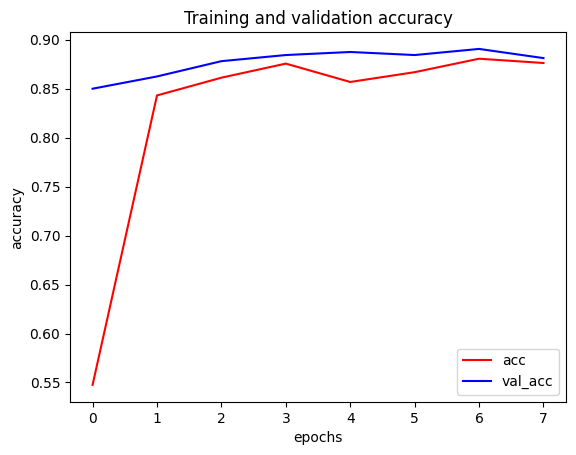

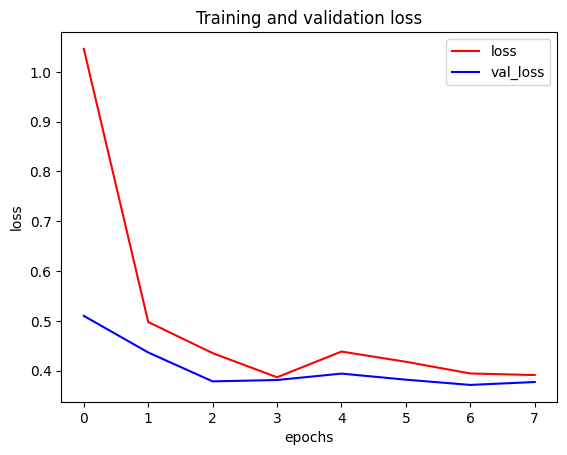

798/798 [==============================] - 244s 302ms/step
Report (Word2Vec + BiLSTM):
              precision    recall  f1-score   support

       world       0.93      0.83      0.88      6380
      sports       0.88      0.99      0.93      6380
    business       0.90      0.76      0.82      6380
        tech       0.80      0.91      0.85      6380

    accuracy                           0.87     25520
   macro avg       0.88      0.87      0.87     25520
weighted avg       0.88      0.87      0.87     25520



In [ ]:
# Word2Vec + BiLSTM

embedding_dim = 64

w2v_bilstm_model = get_bilstm_model(embedding_matrix_w2v)
w2v_bilstm_history = w2v_bilstm_model.fit(X_train_padded,
                                          y_train,
                                          batch_size=64,
                                          epochs=11,
                                          validation_data=(X_val_padded, y_val),
                                          verbose=1,
                                          callbacks=[callback],
                                          validation_steps=5,
                                          steps_per_epoch=25)

w2v_bilstm_model.summary()

plot_graphs(w2v_bilstm_history)

# model evaluation on the test set
w2v_bilstm_pred = [np.argmax(arr) for arr in w2v_bilstm_model.predict(X_test_padded)]

print("Report (Word2Vec + BiLSTM):")
print(classification_report(y_test,
                            w2v_bilstm_pred,
                            target_names=["world", "sports", "business", "tech"]))

Epoch 1/11
25/25 [==============================] - 48s 1s/step - loss: 1.0448 - accuracy: 0.5719 - val_loss: 0.5308 - val_accuracy: 0.7906
Epoch 2/11
25/25 [==============================] - 22s 895ms/step - loss: 0.5136 - accuracy: 0.8344 - val_loss: 0.4683 - val_accuracy: 0.8500
Epoch 3/11
25/25 [==============================] - 30s 1s/step - loss: 0.4761 - accuracy: 0.8506 - val_loss: 0.4403 - val_accuracy: 0.8594
Epoch 4/11
25/25 [==============================] - 29s 1s/step - loss: 0.4953 - accuracy: 0.8363 - val_loss: 0.4601 - val_accuracy: 0.8375
Epoch 5/11
25/25 [==============================] - 24s 939ms/step - loss: 0.4704 - accuracy: 0.8462 - val_loss: 0.4063 - val_accuracy: 0.8687
Epoch 6/11
25/25 [==============================] - 28s 1s/step - loss: 0.4048 - accuracy: 0.8687 - val_loss: 0.3902 - val_accuracy: 0.8781
Epoch 7/11
25/25 [==============================] - 25s 1s/step - loss: 0.4309 - accuracy: 0.8656 - val_loss: 0.3844 - val_accuracy: 0.8719
Epoch 8/11
25/

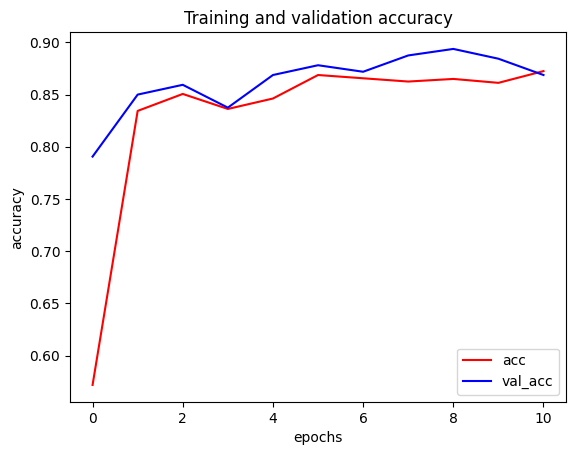

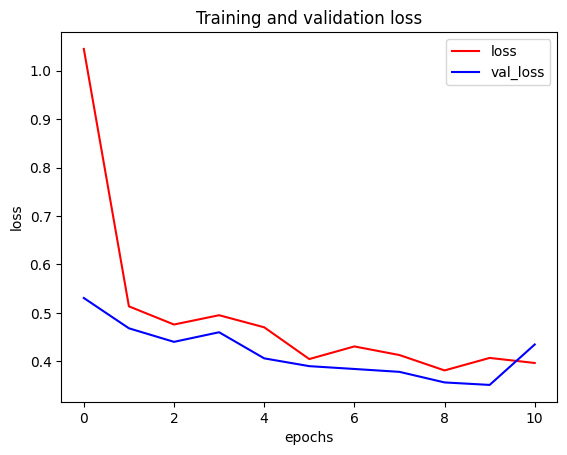

798/798 [==============================] - 200s 248ms/step
Report (Word2Vec + BiLSTM):
              precision    recall  f1-score   support

       world       0.83      0.91      0.87      6380
      sports       0.96      0.93      0.95      6380
    business       0.88      0.81      0.84      6380
        tech       0.84      0.86      0.85      6380

    accuracy                           0.88     25520
   macro avg       0.88      0.88      0.88     25520
weighted avg       0.88      0.88      0.88     25520



In [ ]:
# Glove + BiLSTM

embedding_dim = 100

glove_bilstm_model = get_bilstm_model(embedding_matrix_glove)
glove_bilstm_history = glove_bilstm_model.fit(X_train_padded,
                                              y_train,
                                              batch_size=64,
                                              epochs=11,
                                              validation_data=(X_val_padded, y_val),
                                              verbose=1,
                                              callbacks=[callback],
                                              validation_steps=5,
                                              steps_per_epoch=25)
glove_bilstm_model.summary()

plot_graphs(glove_bilstm_history)

# model evaluation on the test set
glove_bilstm_pred = [np.argmax(arr) for arr in glove_bilstm_model.predict(X_test_padded)]

print("Report (Word2Vec + BiLSTM):")
print(classification_report(y_test,
                            glove_bilstm_pred,
                            target_names=["world", "sports", "business", "tech"]))

Epoch 1/11
149/149 [==============================] - 214s 1s/step - loss: 0.5662 - accuracy: 0.7989 - val_loss: 0.3835 - val_accuracy: 0.8779
Epoch 2/11
149/149 [==============================] - 179s 1s/step - loss: 0.4065 - accuracy: 0.8734 - val_loss: 0.3555 - val_accuracy: 0.8804
Epoch 3/11
149/149 [==============================] - 157s 1s/step - loss: 0.3890 - accuracy: 0.8751 - val_loss: 0.3493 - val_accuracy: 0.8804
Epoch 4/11
149/149 [==============================] - 227s 2s/step - loss: 0.3747 - accuracy: 0.8703 - val_loss: 0.3387 - val_accuracy: 0.8842
Epoch 5/11
149/149 [==============================] - 181s 1s/step - loss: 0.3586 - accuracy: 0.8843 - val_loss: 0.3204 - val_accuracy: 0.8862
Epoch 6/11
149/149 [==============================] - 166s 1s/step - loss: 0.3481 - accuracy: 0.8874 - val_loss: 0.3228 - val_accuracy: 0.8935
Epoch 7/11
149/149 [==============================] - 202s 1s/step - loss: 0.3310 - accuracy: 0.8904 - val_loss: 0.3162 - val_accuracy: 0.8916

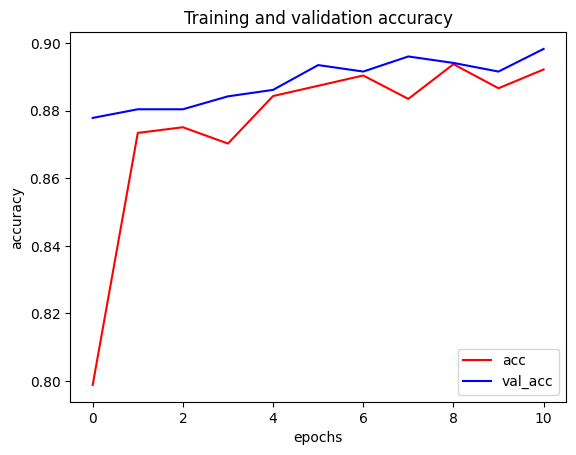

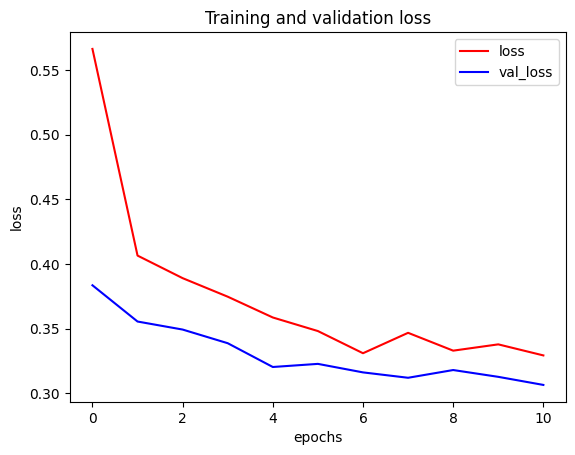

798/798 [==============================] - 258s 323ms/step
Report (FastText + BiLSTM):
              precision    recall  f1-score   support

       world       0.93      0.87      0.90      6380
      sports       0.94      0.98      0.96      6380
    business       0.85      0.87      0.86      6380
        tech       0.88      0.87      0.87      6380

    accuracy                           0.90     25520
   macro avg       0.90      0.90      0.90     25520
weighted avg       0.90      0.90      0.90     25520



In [ ]:
# FastText + BiLSTM

embedding_dim = 100

ft_bilstm_model = get_bilstm_model(embedding_matrix_ft)
ft_bilstm_history = ft_bilstm_model.fit(X_train_padded,
                                        y_train,
                                        batch_size=64,
                                        epochs=15,
                                        validation_data=(X_val_padded, y_val),
                                        verbose=1,
                                        callbacks=[callback],
                                        validation_steps=val_steps,
                                        steps_per_epoch=train_steps)

ft_bilstm_model.summary()

plot_graphs(ft_bilstm_history)

# model evaluation on the test set
ft_bilstm_pred = [np.argmax(arr) for arr in ft_bilstm_model.predict(X_test_padded)]

print("Report (FastText + BiLSTM):")
print(classification_report(y_test,
                            ft_bilstm_pred,
                            target_names=["world", "sports", "business", "tech"]))

#### CNN-RNN

##### 1. CNN-GRU

In [ ]:
def get_cnn_gru_model(embedding_matrix):
  model = Sequential()
  model.add(Embedding(input_dim=vocabulary_size,
                      output_dim=embedding_dim,
                      input_length=max_text_length,
                      weights=[embedding_matrix],
                      trainable=False))
  model.add(Conv1D(filters=64,
                   kernel_size=3,
                   activation="relu"))
  model.add(MaxPooling1D(4))
  model.add(GRU(64, dropout=0.1, recurrent_dropout=0.5))
  model.add(Dense(4, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

  return model

Epoch 1/15
25/25 [==============================] - 9s 131ms/step - loss: 1.1065 - accuracy: 0.6012 - val_loss: 0.7353 - val_accuracy: 0.7844
Epoch 2/15
25/25 [==============================] - 4s 159ms/step - loss: 0.5724 - accuracy: 0.8112 - val_loss: 0.4370 - val_accuracy: 0.8656
Epoch 3/15
25/25 [==============================] - 4s 167ms/step - loss: 0.4348 - accuracy: 0.8475 - val_loss: 0.4227 - val_accuracy: 0.8813
Epoch 4/15
25/25 [==============================] - 4s 163ms/step - loss: 0.4035 - accuracy: 0.8694 - val_loss: 0.4175 - val_accuracy: 0.8781
Epoch 5/15
25/25 [==============================] - 4s 170ms/step - loss: 0.3655 - accuracy: 0.8750 - val_loss: 0.3975 - val_accuracy: 0.8844
Epoch 6/15
25/25 [==============================] - 4s 161ms/step - loss: 0.3429 - accuracy: 0.8825 - val_loss: 0.3859 - val_accuracy: 0.8906
Epoch 7/15
25/25 [==============================] - 3s 116ms/step - loss: 0.3448 - accuracy: 0.8744 - val_loss: 0.4008 - val_accuracy: 0.8719
Epoch 

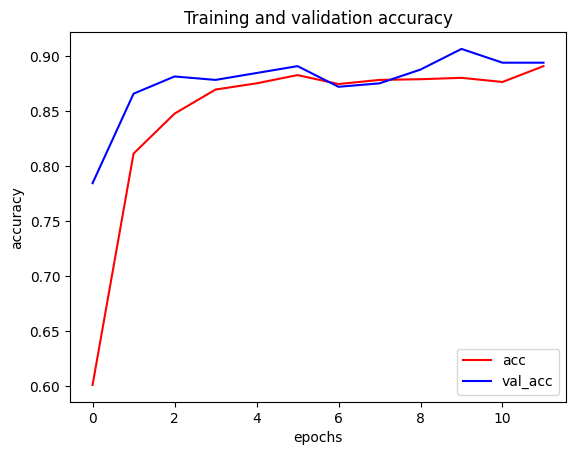

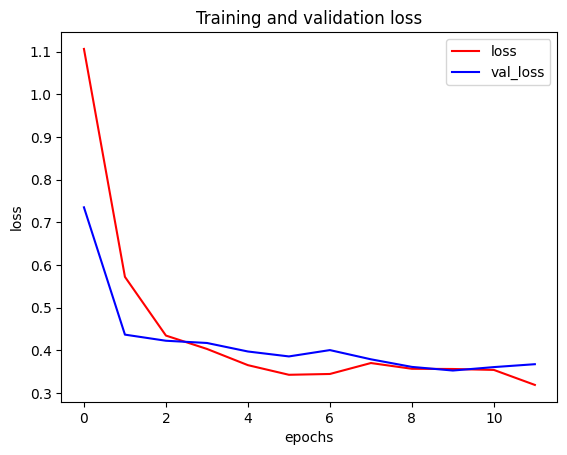

798/798 [==============================] - 18s 22ms/step
Report (Word2Vec + CNN-GRU):
              precision    recall  f1-score   support

       world       0.90      0.88      0.89      6380
      sports       0.94      0.97      0.96      6380
    business       0.86      0.85      0.85      6380
        tech       0.86      0.87      0.86      6380

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520



In [ ]:
# Word2Vec + CNN-GRU

embedding_dim = 64

w2v_cnn_gru_model = get_cnn_gru_model(embedding_matrix_w2v)
w2v_cnn_gru_history = w2v_cnn_gru_model.fit(X_train_padded,
                                            y_train,
                                            batch_size=64,
                                            epochs=15,
                                            validation_data=(X_val_padded, y_val),
                                            callbacks=[callback],
                                            validation_steps=5,
                                            steps_per_epoch=25)
w2v_cnn_gru_model.summary()

plot_graphs(w2v_cnn_gru_history)

# model evaluation on the test set
w2v_cnn_gru_pred = [np.argmax(arr) for arr in w2v_cnn_gru_model.predict(X_test_padded)]

print("Report (Word2Vec + CNN-GRU):")
print(classification_report(y_test,
                            w2v_cnn_gru_pred,
                            target_names=["world", "sports", "business", "tech"]))

Epoch 1/15
149/149 [==============================] - 36s 211ms/step - loss: 0.5478 - accuracy: 0.8062 - val_loss: 0.3595 - val_accuracy: 0.8814
Epoch 2/15
149/149 [==============================] - 19s 129ms/step - loss: 0.3563 - accuracy: 0.8774 - val_loss: 0.3382 - val_accuracy: 0.8842
Epoch 3/15
149/149 [==============================] - 30s 200ms/step - loss: 0.3329 - accuracy: 0.8878 - val_loss: 0.3240 - val_accuracy: 0.8893
Epoch 4/15
149/149 [==============================] - 26s 173ms/step - loss: 0.3326 - accuracy: 0.8814 - val_loss: 0.3246 - val_accuracy: 0.8919
Epoch 5/15
149/149 [==============================] - 19s 131ms/step - loss: 0.3317 - accuracy: 0.8861 - val_loss: 0.3176 - val_accuracy: 0.8900
Epoch 6/15
149/149 [==============================] - 27s 181ms/step - loss: 0.3187 - accuracy: 0.8924 - val_loss: 0.3106 - val_accuracy: 0.8957
Epoch 7/15
149/149 [==============================] - 29s 194ms/step - loss: 0.3210 - accuracy: 0.8882 - val_loss: 0.3219 - val_ac

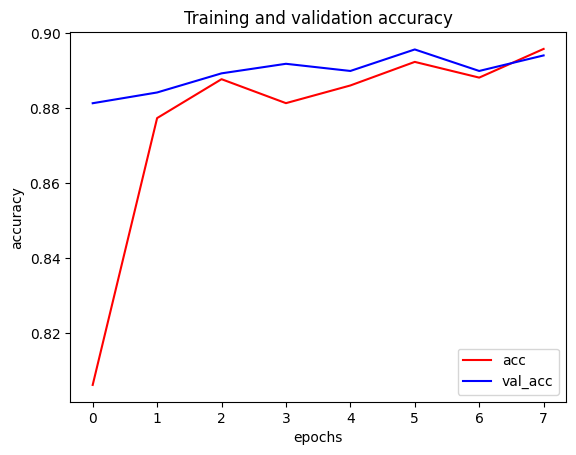

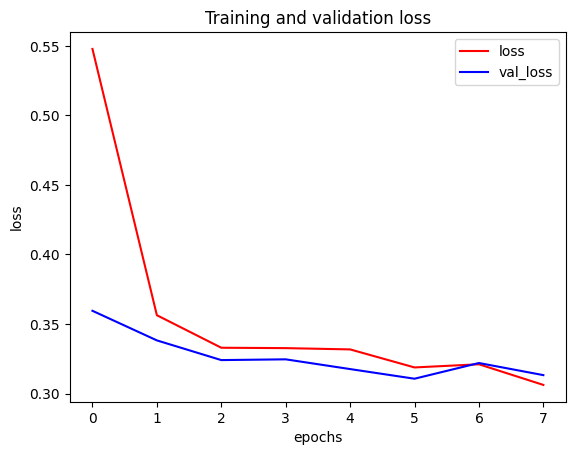

798/798 [==============================] - 16s 19ms/step
Report (Glove + CNN-GRU):
              precision    recall  f1-score   support

       world       0.93      0.87      0.90      6380
      sports       0.95      0.98      0.96      6380
    business       0.90      0.81      0.85      6380
        tech       0.82      0.92      0.87      6380

    accuracy                           0.90     25520
   macro avg       0.90      0.90      0.90     25520
weighted avg       0.90      0.90      0.90     25520



In [ ]:
# Glove + CNN-GRU

embedding_dim = 100

glove_cnn_gru_model = get_cnn_gru_model(embedding_matrix_glove)
glove_cnn_gru_history = glove_cnn_gru_model.fit(X_train_padded,
                                                y_train,
                                                batch_size=64,
                                                epochs=15,
                                                validation_data=(X_val_padded, y_val),
                                                verbose=1,
                                                callbacks=[callback],
                                                validation_steps=val_steps,
                                                steps_per_epoch=train_steps)
glove_cnn_gru_model.summary()

plot_graphs(glove_cnn_gru_history)

# model evaluation on the test set
glove_cnn_gru_pred = [np.argmax(arr) for arr in glove_cnn_gru_model.predict(X_test_padded)]

print("Report (Glove + CNN-GRU):")
print(classification_report(y_test,
                            glove_cnn_gru_pred,
                            target_names=["world", "sports", "business", "tech"]))

Epoch 1/10
149/149 [==============================] - 31s 177ms/step - loss: 0.5310 - accuracy: 0.8158 - val_loss: 0.3567 - val_accuracy: 0.8846
Epoch 2/10
149/149 [==============================] - 20s 137ms/step - loss: 0.3633 - accuracy: 0.8750 - val_loss: 0.3365 - val_accuracy: 0.8868
Epoch 3/10
149/149 [==============================] - 19s 126ms/step - loss: 0.3452 - accuracy: 0.8813 - val_loss: 0.3223 - val_accuracy: 0.8935
Epoch 4/10
149/149 [==============================] - 29s 195ms/step - loss: 0.3193 - accuracy: 0.8885 - val_loss: 0.3192 - val_accuracy: 0.8906
Epoch 5/10
149/149 [==============================] - 28s 189ms/step - loss: 0.3183 - accuracy: 0.8899 - val_loss: 0.3275 - val_accuracy: 0.8890
Epoch 6/10
149/149 [==============================] - 18s 120ms/step - loss: 0.3171 - accuracy: 0.8910 - val_loss: 0.3144 - val_accuracy: 0.8945
Epoch 7/10
149/149 [==============================] - 24s 161ms/step - loss: 0.2980 - accuracy: 0.8993 - val_loss: 0.3156 - val_ac

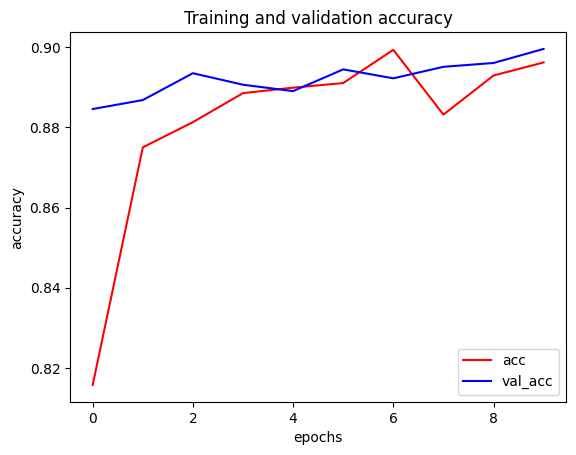

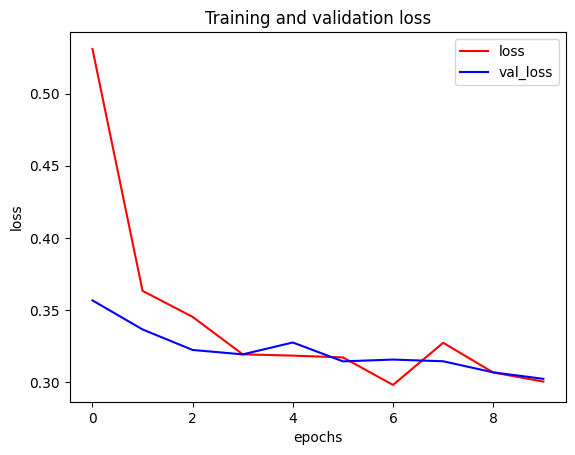

798/798 [==============================] - 19s 23ms/step
Report (FastText + CNN-GRU):
              precision    recall  f1-score   support

       world       0.93      0.87      0.90      6380
      sports       0.95      0.98      0.97      6380
    business       0.86      0.86      0.86      6380
        tech       0.85      0.89      0.87      6380

    accuracy                           0.90     25520
   macro avg       0.90      0.90      0.90     25520
weighted avg       0.90      0.90      0.90     25520



In [ ]:
# FastText + CNN-GRU

embedding_dim = 100

ft_cnn_gru_model = get_cnn_gru_model(embedding_matrix_ft)
ft_cnn_gru_history = ft_cnn_gru_model.fit(X_train_padded,
                                          y_train,
                                          batch_size=64,
                                          epochs=10,
                                          validation_data=(X_val_padded, y_val),
                                          verbose=1,
                                          callbacks=[callback],
                                          steps_per_epoch=train_steps,
                                          validation_steps=val_steps)

ft_cnn_gru_model.summary()

plot_graphs(ft_cnn_gru_history)

# model evaluation on the test set
ft_cnn_gru_pred = [np.argmax(arr) for arr in ft_cnn_gru_model.predict(X_test_padded)]

print("Report (FastText + CNN-GRU):")
print(classification_report(y_test,
                            ft_cnn_gru_pred,
                            target_names=["world", "sports", "business", "tech"]))

##### 2. CNN-BiLSTM

In [ ]:
def get_cnn_bilstm_model(embedding_matrix):
  model = Sequential()
  model.add(Embedding(input_dim=vocabulary_size,
                      output_dim=embedding_dim,
                      input_length=max_text_length,
                      weights=[embedding_matrix],
                      trainable=False))
  model.add(Conv1D(filters=64,
                   kernel_size=5,
                   activation="relu"))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters=64,
                   kernel_size=5,
                   activation="relu"))
  model.add(Bidirectional(LSTM(64))) # we add one bidirectional LSTM layer to handle the CNNs features from both directions
  model.add(Dense(32, activation="relu"))
  model.add(Dropout(0.3))
  model.add(Dense(4, activation='softmax'))

  model.compile(loss="sparse_categorical_crossentropy",
                optimizer = "adam",
                metrics = ["accuracy"])

  return model

Epoch 1/11
25/25 [==============================] - 11s 233ms/step - loss: 1.0571 - accuracy: 0.5412 - val_loss: 0.6754 - val_accuracy: 0.7937
Epoch 2/11
25/25 [==============================] - 7s 292ms/step - loss: 0.5642 - accuracy: 0.8069 - val_loss: 0.4195 - val_accuracy: 0.8500
Epoch 3/11
25/25 [==============================] - 8s 313ms/step - loss: 0.4773 - accuracy: 0.8444 - val_loss: 0.4311 - val_accuracy: 0.8656
Epoch 4/11
25/25 [==============================] - 7s 262ms/step - loss: 0.4836 - accuracy: 0.8456 - val_loss: 0.4150 - val_accuracy: 0.8781
Epoch 5/11
25/25 [==============================] - 4s 160ms/step - loss: 0.4533 - accuracy: 0.8544 - val_loss: 0.4065 - val_accuracy: 0.8750
Epoch 6/11
25/25 [==============================] - 4s 158ms/step - loss: 0.4039 - accuracy: 0.8694 - val_loss: 0.4118 - val_accuracy: 0.8687
Epoch 7/11
25/25 [==============================] - 7s 267ms/step - loss: 0.4186 - accuracy: 0.8631 - val_loss: 0.4127 - val_accuracy: 0.8687
Epoch

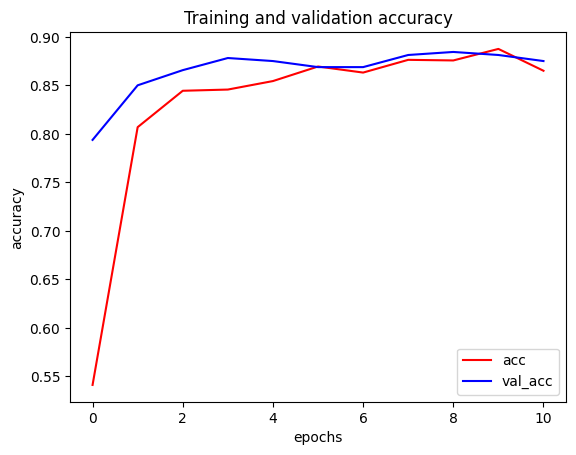

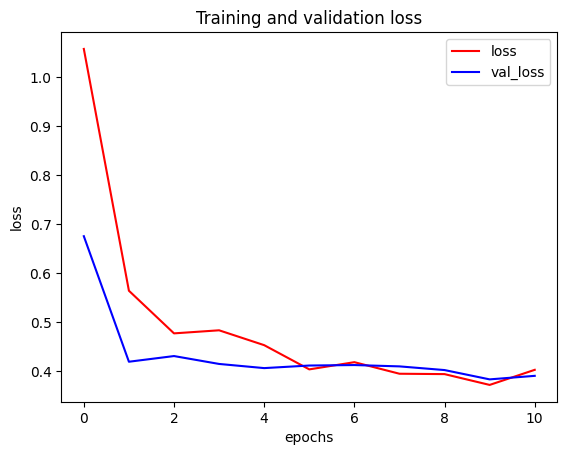

798/798 [==============================] - 37s 45ms/step
Report (Word2Vec + CNN-BiLSTM):
              precision    recall  f1-score   support

       world       0.87      0.89      0.88      6380
      sports       0.95      0.95      0.95      6380
    business       0.84      0.86      0.85      6380
        tech       0.87      0.83      0.85      6380

    accuracy                           0.88     25520
   macro avg       0.88      0.88      0.88     25520
weighted avg       0.88      0.88      0.88     25520



In [ ]:
# Word2Vec + CNN-BiLSTM

embedding_dim = 64

w2v_cnn_bilstm_model = get_cnn_bilstm_model(embedding_matrix_w2v)
w2v_cnn_bilstm_history = w2v_cnn_bilstm_model.fit(X_train_padded,
                                                  y_train,
                                                  batch_size=64,
                                                  epochs=11,
                                                  validation_data=(X_val_padded, y_val),
                                                  verbose=1,
                                                  callbacks=[callback],
                                                  validation_steps=5,
                                                  steps_per_epoch=25)

w2v_cnn_bilstm_model.summary()

plot_graphs(w2v_cnn_bilstm_history)

# model evaluation on the test set
w2v_cnn_bilstm_pred = [np.argmax(arr) for arr in w2v_cnn_bilstm_model.predict(X_test_padded)]

print("Report (Word2Vec + CNN-BiLSTM):")
print(classification_report(y_test,
                            w2v_cnn_bilstm_pred,
                            target_names=["world", "sports", "business", "tech"]))

Epoch 1/13
149/149 [==============================] - 117s 299ms/step - loss: 0.5751 - accuracy: 0.7976 - val_loss: 0.3910 - val_accuracy: 0.8658
Epoch 2/13
149/149 [==============================] - 43s 289ms/step - loss: 0.4019 - accuracy: 0.8704 - val_loss: 0.3648 - val_accuracy: 0.8769
Epoch 3/13
149/149 [==============================] - 40s 268ms/step - loss: 0.3796 - accuracy: 0.8790 - val_loss: 0.3613 - val_accuracy: 0.8750
Epoch 4/13
149/149 [==============================] - 41s 276ms/step - loss: 0.3673 - accuracy: 0.8827 - val_loss: 0.3442 - val_accuracy: 0.8788
Epoch 5/13
149/149 [==============================] - 55s 371ms/step - loss: 0.3723 - accuracy: 0.8764 - val_loss: 0.3348 - val_accuracy: 0.8804
Epoch 6/13
149/149 [==============================] - 41s 276ms/step - loss: 0.3526 - accuracy: 0.8839 - val_loss: 0.3192 - val_accuracy: 0.8916
Epoch 7/13
149/149 [==============================] - 52s 351ms/step - loss: 0.3488 - accuracy: 0.8856 - val_loss: 0.3380 - val_a

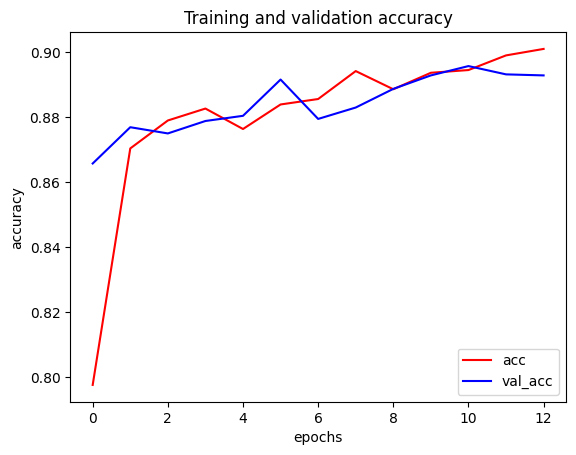

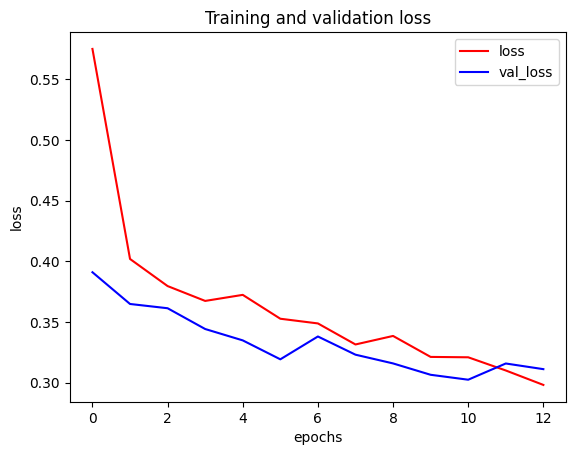

798/798 [==============================] - 42s 51ms/step
Report (Glove + CNN-BiLSTM):
              precision    recall  f1-score   support

       world       0.94      0.87      0.90      6380
      sports       0.94      0.99      0.96      6380
    business       0.82      0.89      0.86      6380
        tech       0.89      0.84      0.86      6380

    accuracy                           0.90     25520
   macro avg       0.90      0.90      0.90     25520
weighted avg       0.90      0.90      0.90     25520



In [ ]:
# Glove + BiLSTM

embedding_dim = 100

glove_cnn_bilstm_model = get_cnn_bilstm_model(embedding_matrix_glove)
glove_cnn_bilstm_history = glove_cnn_bilstm_model.fit(X_train_padded,
                                                      y_train,
                                                      batch_size=64,
                                                      epochs=13,
                                                      validation_data=(X_val_padded, y_val),
                                                      verbose=1,
                                                      callbacks=[callback],
                                                      validation_steps=val_steps,
                                                      steps_per_epoch=train_steps)
glove_cnn_bilstm_model.summary()

plot_graphs(glove_cnn_bilstm_history)

# model evaluation on the test set
glove_cnn_bilstm_pred = [np.argmax(arr) for arr in glove_cnn_bilstm_model.predict(X_test_padded)]

print("Report (Glove + CNN-BiLSTM):")
print(classification_report(y_test,
                            glove_cnn_bilstm_pred,
                            target_names=["world", "sports", "business", "tech"]))

Epoch 1/9
149/149 [==============================] - 40s 209ms/step - loss: 0.6124 - accuracy: 0.7714 - val_loss: 0.3764 - val_accuracy: 0.8763
Epoch 2/9
149/149 [==============================] - 27s 179ms/step - loss: 0.4187 - accuracy: 0.8708 - val_loss: 0.3690 - val_accuracy: 0.8798
Epoch 3/9
149/149 [==============================] - 30s 205ms/step - loss: 0.3896 - accuracy: 0.8764 - val_loss: 0.3764 - val_accuracy: 0.8686
Epoch 4/9
149/149 [==============================] - 30s 202ms/step - loss: 0.3673 - accuracy: 0.8805 - val_loss: 0.3359 - val_accuracy: 0.8858
Epoch 5/9
149/149 [==============================] - 27s 181ms/step - loss: 0.3588 - accuracy: 0.8828 - val_loss: 0.3508 - val_accuracy: 0.8868
Epoch 6/9
149/149 [==============================] - 31s 206ms/step - loss: 0.3428 - accuracy: 0.8950 - val_loss: 0.3393 - val_accuracy: 0.8839
Epoch 7/9
149/149 [==============================] - 31s 206ms/step - loss: 0.3498 - accuracy: 0.8878 - val_loss: 0.3586 - val_accuracy:

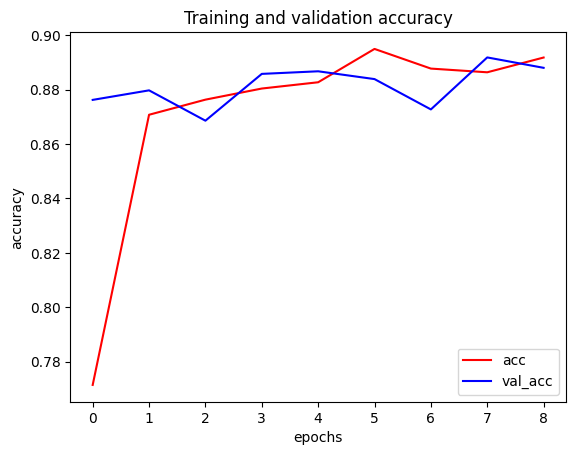

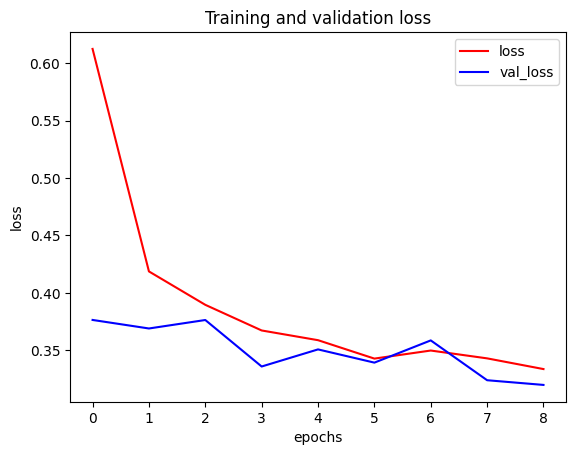

798/798 [==============================] - 27s 33ms/step
Report (FastText + CNN-BiLSTM):
              precision    recall  f1-score   support

       world       0.94      0.86      0.90      6380
      sports       0.95      0.98      0.96      6380
    business       0.89      0.82      0.85      6380
        tech       0.82      0.93      0.87      6380

    accuracy                           0.90     25520
   macro avg       0.90      0.90      0.90     25520
weighted avg       0.90      0.90      0.90     25520



In [ ]:
# FastText + CNN-BiLSTM

embedding_dim = 100

ft_cnn_bilstm_model = get_cnn_bilstm_model(embedding_matrix_ft)
ft_cnn_bilstm_history = ft_cnn_bilstm_model.fit(X_train_padded,
                                                y_train,
                                                batch_size=64,
                                                epochs=9,
                                                validation_data=(X_val_padded, y_val),
                                                verbose=1,
                                                callbacks=[callback],
                                                steps_per_epoch=train_steps,
                                                validation_steps=val_steps)

ft_cnn_bilstm_model.summary()

plot_graphs(ft_cnn_bilstm_history)

# model evaluation on the test set
ft_cnn_bilstm_pred = [np.argmax(arr) for arr in ft_cnn_bilstm_model.predict(X_test_padded)]

print("Report (FastText + CNN-BiLSTM):")
print(classification_report(y_test,
                            ft_cnn_bilstm_pred,
                            target_names=["world", "sports", "business", "tech"]))

## 7. Conclusion

**I.** In this laboratory work we trained 15 models:
  1. CNN **with Word2Vec** Embedding layer
  2. CNN **with Glove** Embedding layer
  3. CNN **with FastText** Embedding layer
  4. LSTM **with Word2Vec** Embedding layer
  5. LSTM **with Glove** Embedding layer
  6. LSTM **with FastText** Embedding layer
  7. BiLSTM **with Word2Vec** Embedding layer
  8. BiLSTM **with Glove** Embedding layer
  9. BiLSTM **with Glove** Embedding layer
  10. CNN-GRU **with Word2Vec** Embedding layer
  11. CNN-GRU **with Glove** Embedding layer
  12. CNN-GRU **with Glove** Embedding layer
  13. CNN-BiLSTM **with Word2Vec** Embedding layer
  14. CNN-BiLSTM **with Glove** Embedding layer
  15. CNN-BiLSTM **with Glove** Embedding layer

**II.** Models Evaluation

  * Overall, all models exhibit some degree of overfitting
  * Some possible solutions were applied to tackle this problem, including regularization, BatchNormalization, Dropouts; however, they didn't improve the models' performance
  * In accordance with the f1-score metric, the models best predict the “Sports” class, “World” is in second place, “Technology” is in third place, and “Business” is in fourth place. Initially we thought that this was due to the length of the text (texts about sports are longer and contain more features). However, EDA showed that the average length of texts about sports is shorter. We can conclude that our models also work well on short texts.
  * Overall performance of models is in the table below

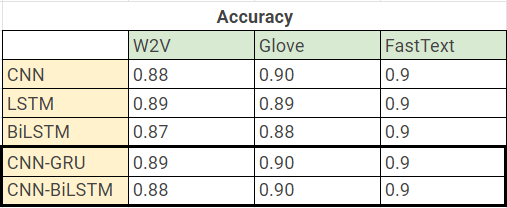

* Models with **FastText** show slightly better performance than models with **Word2Vec** or **Glove** Embeddings. This confirms similar conclusion ("FastText <...> generally outperforms other combinations") obtained by the authors of the article (Wang et al., 2021). In addition, our findings show that models with **Glove** are slightly better than with **Word2Vec** Embedding.

* Our **jointed models** (CNN-GRU, CNN-BiLSTM) show slightly **better** results. Although the difference in the accuracy metric is not great, it still exists. Thus, the conclusion made in the article (Wang et al., 2016; Murfi et al., 2022) was also confirmed.



## Reference
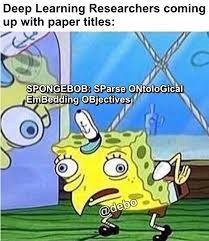

* https://aclanthology.org/C16-1229.pdf
* https://arxiv.org/ftp/arxiv/papers/2211/2211.05273.pdf
* https://dl.acm.org/doi/pdf/10.1145/3443279.3443304

## In conclusion...
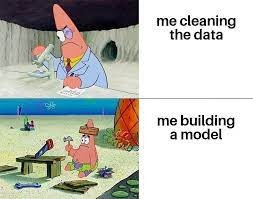